In this notebook, we shall use a single-cell RNAseq data to deconvolve a bulk RNAseq data.

## Datasets needed for tutorial

The datasets used in this tutorial are available as part the [DISSECT](https://github.com/robinredX/DISSECT/tutorials/data) repository. 

Sources:

The bulk RNAseq data is taken from [GSE120502](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE120502).

The single-cell RNAseq data comes from 10x Genomics and for this tutorial, we will use a sampled dataset containing 1000 cells. The complete count matrix can be downloaded at [this link] (http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz). 

### A note on the supported formats

**(1) bulkRNAseq**

A tab seperated file (gene symbols in rows, sample names in columns) as can be seen below:

In [1]:
import pandas as pd

bulk_path = "data/bulkRNAseq/bulk_gse120502.txt"

df = pd.read_table(bulk_path, index_col=0)
df.head()

T63_LPS_FC1_4  T81_LPS_FC1_4  T104_LPS_FC1_4  T4_GARD_BATCH_2  \
ATF7-NPFF              29.0           28.0            38.0             71.0   
B4GAT1-DT              15.0           16.0            28.0             44.0   
BTBD8                   0.0            3.0             4.0             36.0   
C12orf42-AS1            0.0            0.0             0.0              0.0   
C4orf54                 0.0            2.0             0.0              6.0   

              K47_LPS_FC1_4  T4_CTL_FC5  T12_CTL_B_BATCH_2  T84_LPS_FC1_4  \
ATF7-NPFF              40.0        34.0               39.0           25.0   
B4GAT1-DT               7.0        24.0               44.0           28.0   
BTBD8                  13.0         6.0               30.0           23.0   
C12orf42-AS1            0.0         0.0                0.0            0.0   
C4orf54                 0.0         0.0                0.0            0.0   

              K44_LPS_FC1_4  K10_LPS_FC1_4  ...  T70_LPS_FC1_4  \
ATF7-NPFF              58.0           38.0  ...           30.0   
B4GAT1-DT              23.0           18.0  ...           32.0   
BTBD8                  37.0           13.0  ...            5.0   
C12orf42-AS1            0.0            0.0  ...            0.0   
C4orf54                 0.0            0.0  ...            0.0   

              K10_GARD_BATCH_2  K37_CTL_FC1_4  T5_CTL_FC5  K53_LPS_FC1_4  \
ATF7-NPFF                 52.0           31.0        27.0           34.0   
B4GAT1-DT                 24.0           18.0        36.0           13.0   
BTBD8                     12.0           16.0        25.0            0.0   
C12orf42-AS1               0.0            0.0         0.0            0.0   
C4orf54                    0.0            2.0         1.0            0.0   

              T120_LPS_FC5  K7_GARD_BATCH_2  K12_GARD_BATCH_2  \
ATF7-NPFF             22.0             56.0              50.0   
B4GAT1-DT              4.0             43.0              37.0   
BTBD8                  0.0             23.0              22.0   
C12orf42-AS1           0.0              0.0               0.0   
C4orf54                0.0              0.0               0.0   

              T35_GARD_BATCH_2  K50_CTL_FC1_4  
ATF7-NPFF                 50.0           24.0  
B4GAT1-DT                 47.0           16.0  
BTBD8                     46.0           32.0  
C12orf42-AS1               0.0            0.0  
C4orf54                    0.0            1.0  

[5 rows x 250 columns]

The other supported format is h5ad compatible with Scanpy >=1.8.0.

**(2) scRNAseq**

A h5ad compatible with Scanpy >=1.8.0.
Metadata included in .obs attribute as can be seen below:

In [2]:
import scanpy as sc
sc_path = "data/scRNAseq/sampled_100_data8k.h5ad"
adata = sc.read(sc_path)
adata

AnnData object with n_obs × n_vars = 1000 × 18159
    obs: 'cell_type'

## Import DISSECT module

In [1]:
import dissect

DISSECT can be configured with a config file available from the following command.

In [2]:
config = dissect.config

In [5]:
config

{'experiment_folder': '/home/user/experiment',
 'simulation_params': {'scdata': '/home/user/experiment/data.h5ad',
  'n_samples': None,
  'type': 'bulk',
  'celltype_col': 'celltype',
  'batch_col': None,
  'cells_per_sample': None,
  'downsample': None,
  'preprocess': None,
  'filter': {'min_genes': 200, 'min_cells': 3, 'mt_cutoff': 5, 'min_expr': 0},
  'concentration': None,
  'prop_sparse': 0.5,
  'generate_component_figures': True},
 'deconv_params': {'test_dataset': '../bulk.txt',
  'test_dataset_format': 'txt',
  'test_dataset_type': 'bulk',
  'duplicated': 'first',
  'normalize_simulated': 'cpm',
  'normalize_test': 'cpm',
  'var_cutoff': 0.1,
  'test_in_mix': None,
  'simulated': True,
  'sig_matrix': False,
  'mix': 'srm',
  'save_config': True,
  'network_params': {'n_hidden_layers': 4,
   'hidden_units': [512, 256, 128, 64],
   'hidden_activation': 'relu6',
   'output_activation': 'softmax',
   'loss': 'kldivergence',
   'n_steps': 5000,
   'lr': 1e-05,
   'batch_size': 64,

## Set experiment folder

In this config, **experiment_folder** specifies a non-existing experiment directory where the results would be stored

In [6]:
config["experiment_folder"] # this prints the current folder

'/home/user/experiment'

In [3]:
# we will set it to "tutorial_bulkRNAseq"

config["experiment_folder"] = "tutorial_bulkRNAseq"

## Do simulation

**simulation_params** contain hyperparameters for simulations

We can specify the path to our single-cell data, the data type, our cell type column name, and the number of samples to simulate

In [4]:
config["simulation_params"]["scdata"] = "data/scRNAseq/sampled_100_data8k.h5ad"
config["simulation_params"]["type"] = "bulk"
config["simulation_params"]["celltype_col"] = "cell_type"

In [5]:
# by default the single-cell data passes through following QC:
config["simulation_params"]["filter"]

{'min_genes': 200, 'min_cells': 3, 'mt_cutoff': 5, 'min_expr': 0}

We will leave all other For other options in the config and their meanings, please look [here](https://github.com/imsb-uke/DISSECT/blob/main/dissect/configs/config.py).

**simulate** function from dissect can be used for simulation. It takes as input the above config.

Outputs

**(1) Simulated data**

Saves the simulated data as h5ad object in the folder simulations/simulated.h5ad within the config["experiment_folder"].

**(2) Plots**

The function also prints and saves the following if config["generate_component_figures"] is set to True (default):

(1) boxplots showing the proportions of cell types in the simulated data,

(2) a scatter plot showing principal components of the simulated data colored by cell type proportions, and

(3) a scatter plot showing principal components of the cell type-specific gene expression profiles for each sample.

Number of batches in single-cell data is 1. If this is incorrect, please specify name of the batch column as in the single-cell data object (.obs)


100%|██████████████████████████████████████████████████████████| 6000/6000 [01:49<00:00, 54.98it/s]


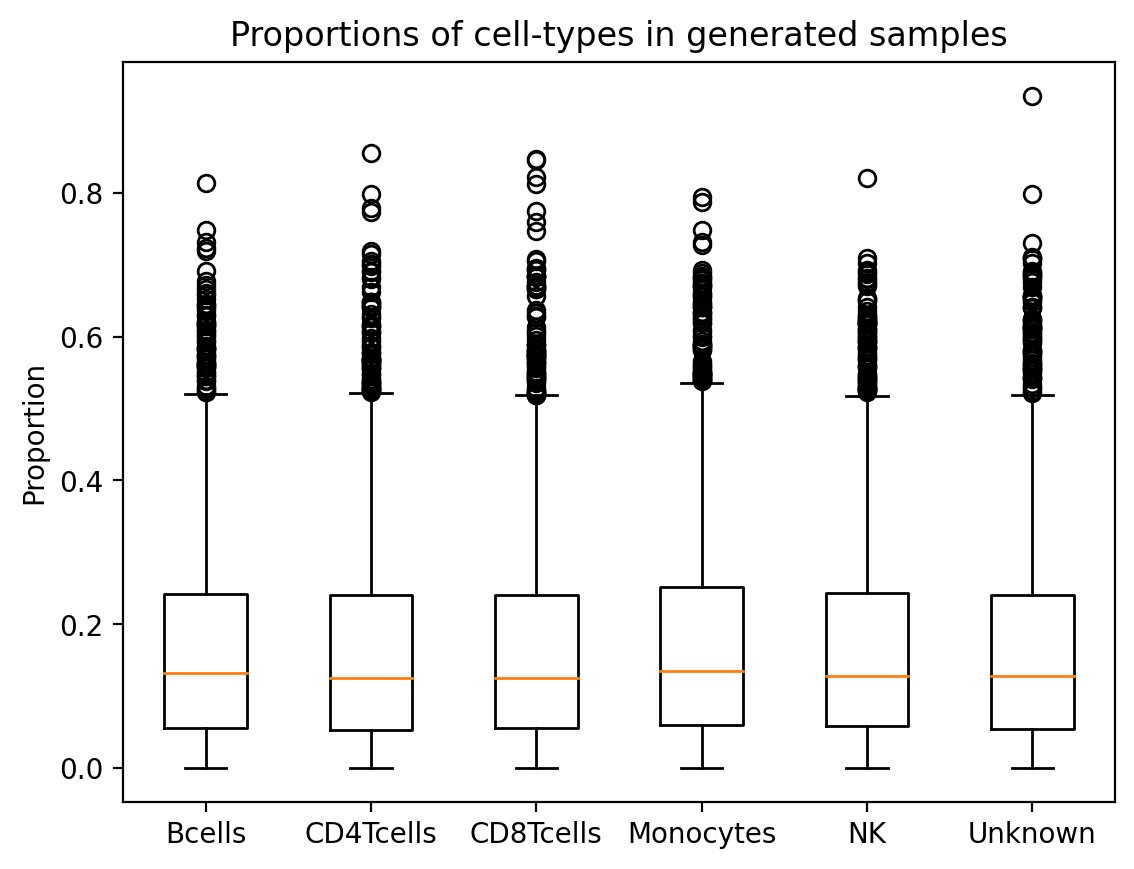

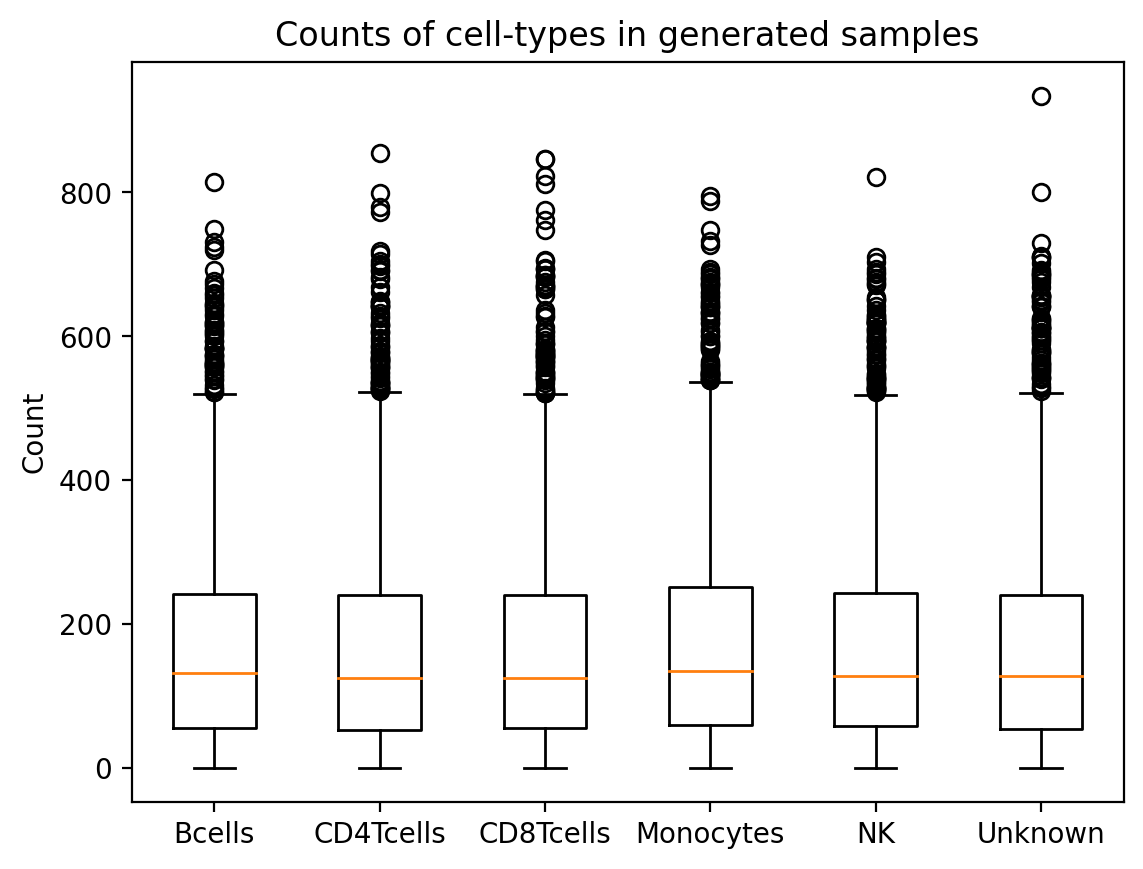

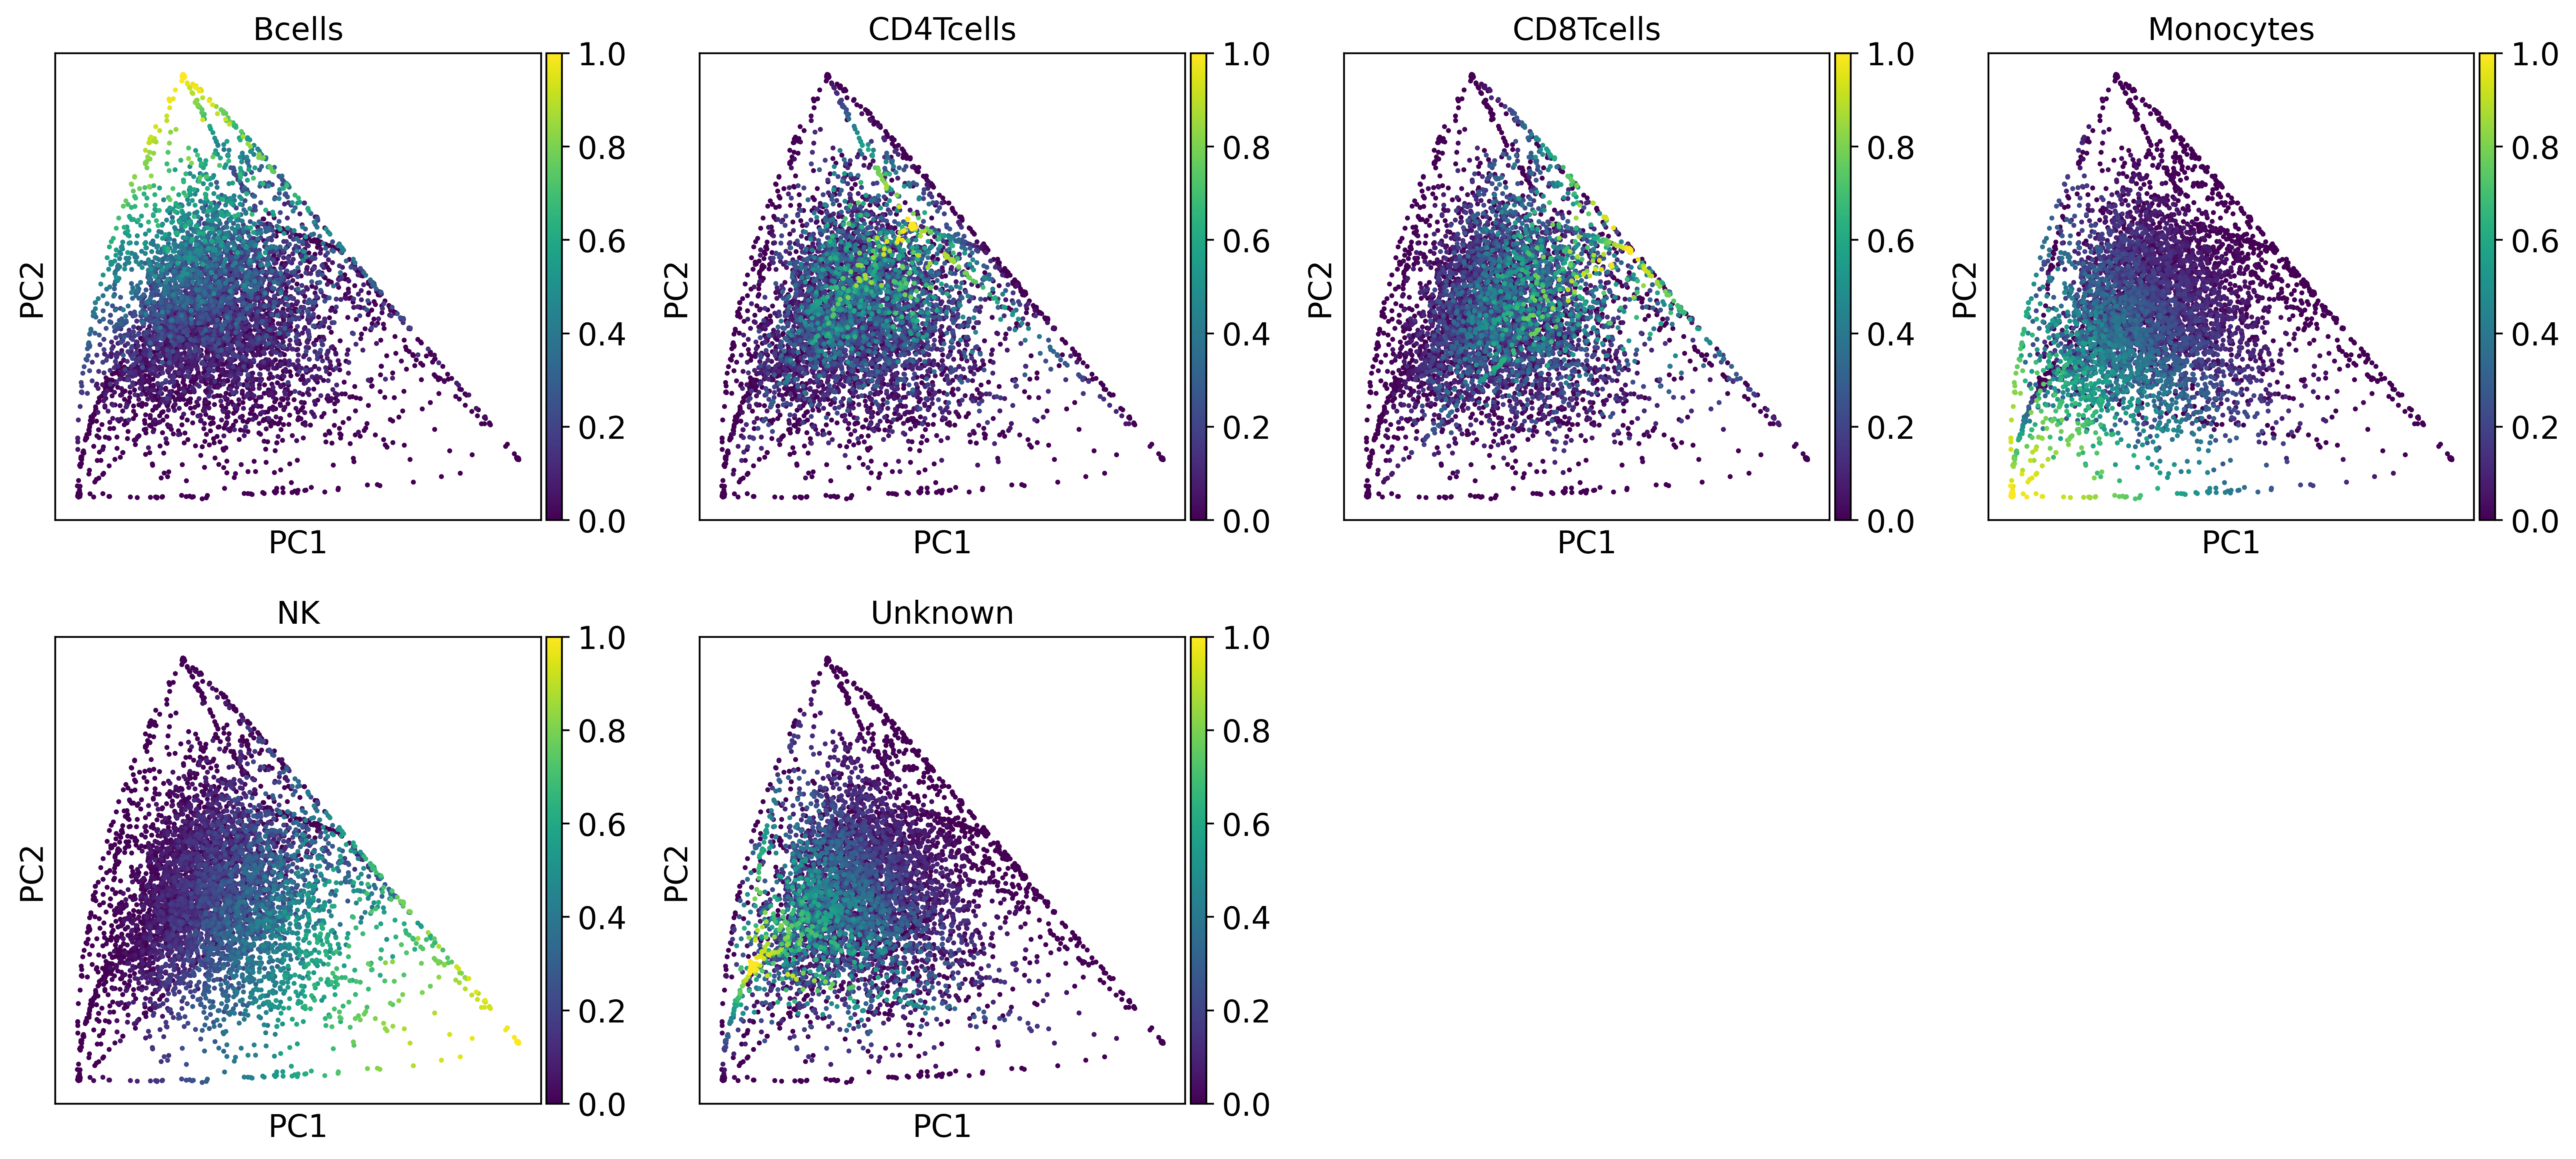

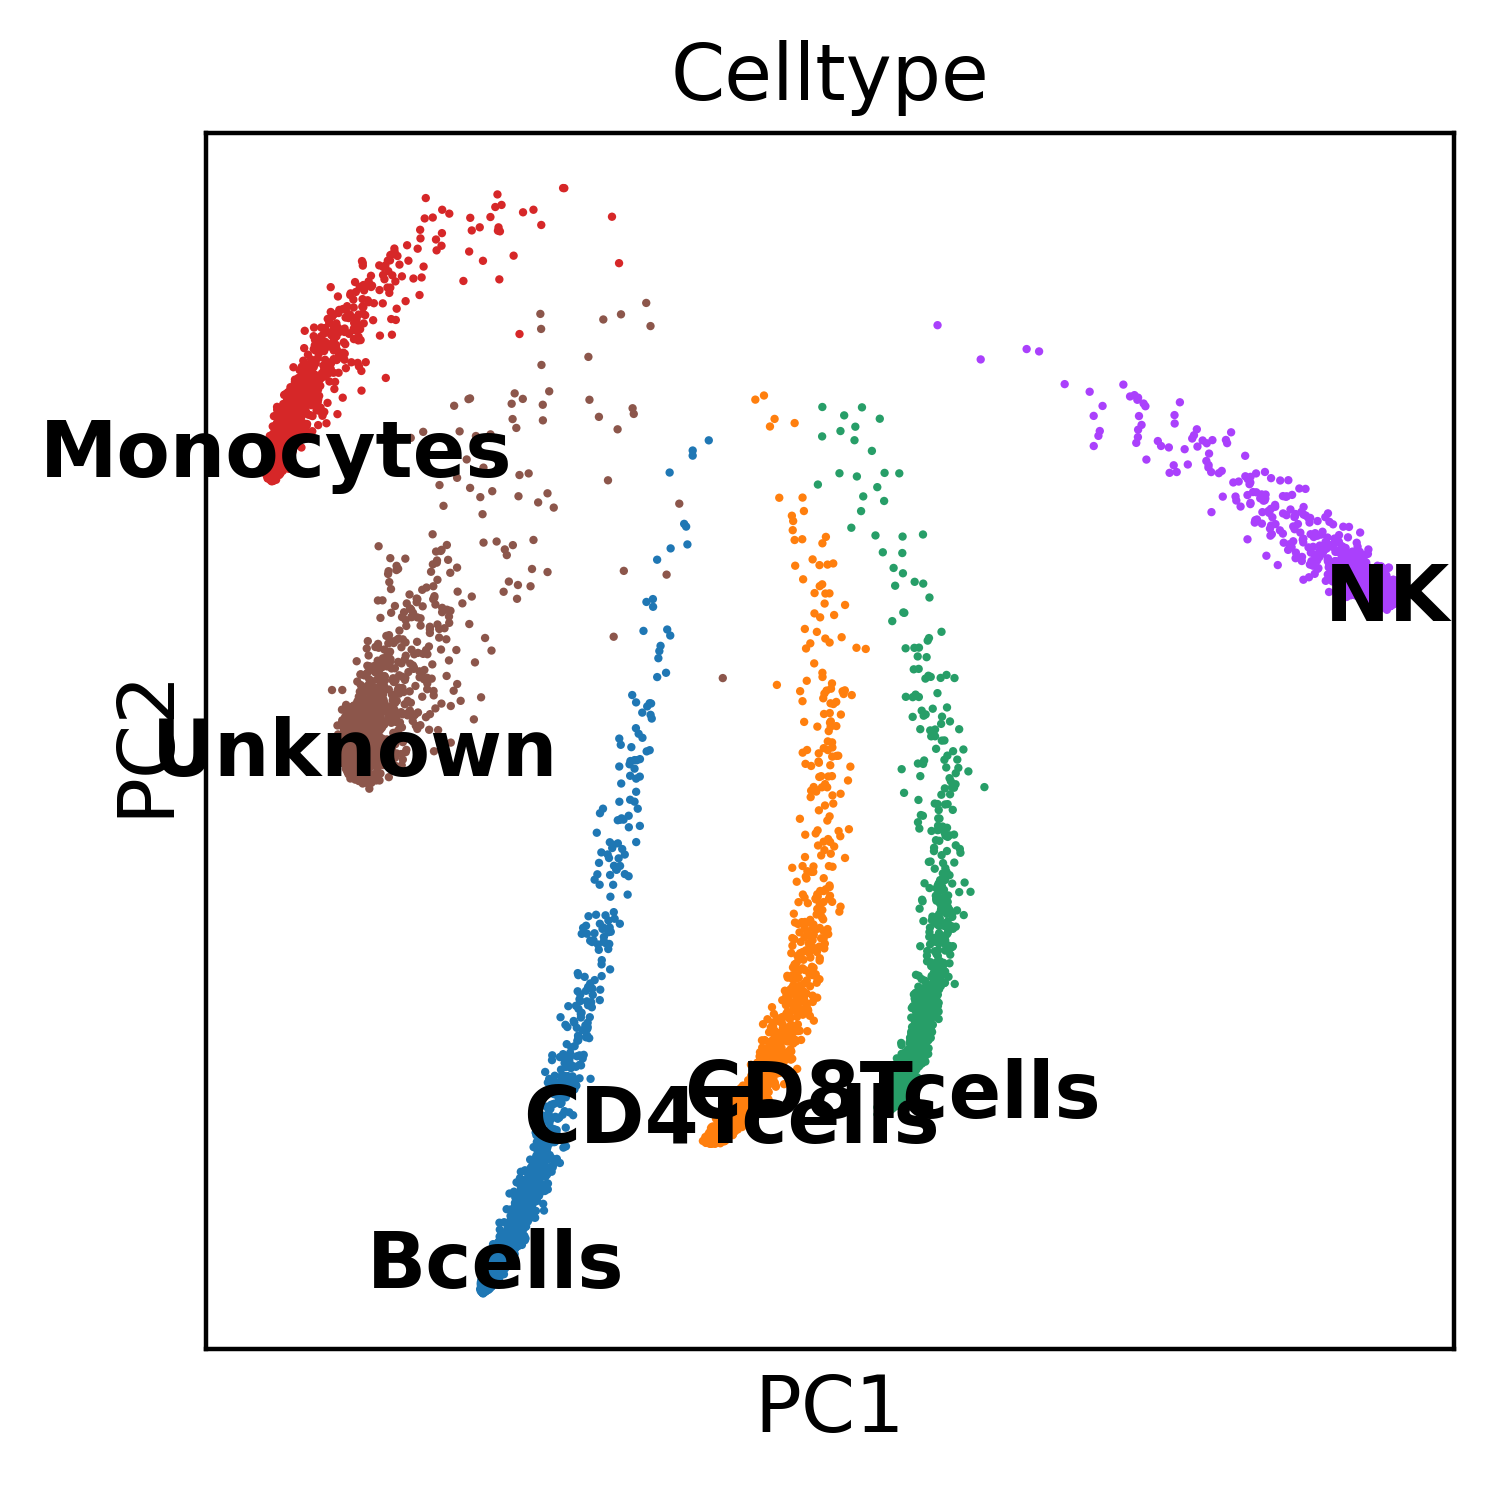

In [10]:
dissect.simulate(config)

# Estimation of fractions

To do this with default parameters, we just need to specify path to bulkRNAseq dataset and its data type

In [6]:
config["deconv_params"]["test_dataset"] = "data/bulkRNAseq/bulk_gse120502.txt"
config["deconv_params"]["test_dataset_format"] = "txt"

In [12]:
# preprocess data
# It does CPM normalization and filters out gene with low variance (default cutoff 0.1).

dissect.dataset(config)

Removing genes which have less than 0.1 variance in their expressions.
test dataset has 16872 distinct and variable genes.
simulated dataset has 13669 distinct genes.
There are 11505 common genes between simulated and test dataset.
Saving numpy files.
Done.


In [13]:
# Estimate fractions
dissect.run_dissect_frac(config)

Loading prepared datasets...
Starting training model 0


step: 5000| loss: 0.0107: 100%|████████████████████████████████| 5000/5000 [10:20<00:00,  8.05it/s]


Starting training model 1


step: 5000| loss: 0.0114: 100%|████████████████████████████████| 5000/5000 [10:40<00:00,  7.81it/s]


Starting training model 2


step: 5000| loss: 0.0103: 100%|████████████████████████████████| 5000/5000 [10:40<00:00,  7.80it/s]


Starting training model 3


step: 5000| loss: 0.0126: 100%|████████████████████████████████| 5000/5000 [10:27<00:00,  7.97it/s]


Starting training model 4


step: 5000| loss: 0.0100: 100%|████████████████████████████████| 5000/5000 [10:16<00:00,  8.11it/s]


Predictions are saved to tutorial_bulkRNAseq/dissect_fractions.txt


The resulting files for each model is saved as dissect_fractions_[model_number].txt in the experiment folder specified in config["experiment_folder"].

Let's load our results and see how it is structured, how we can visualize it and use it for downstream analysis.

In [14]:
import os
result_path = os.path.join(config["experiment_folder"],
                          "dissect_fractions.txt")

df = pd.read_table(result_path, index_col=0)
df.head()

Bcells  CD4Tcells  CD8Tcells  Monocytes        NK   Unknown
T63_LPS_FC1_4    0.043680   0.286839   0.320540   0.166670  0.097324  0.084946
T81_LPS_FC1_4    0.112386   0.348355   0.254774   0.132866  0.055171  0.096448
T104_LPS_FC1_4   0.038350   0.494505   0.253355   0.092494  0.056181  0.065115
T4_GARD_BATCH_2  0.077482   0.363703   0.323723   0.081566  0.082375  0.071151
K47_LPS_FC1_4    0.067217   0.317589   0.255737   0.185548  0.075936  0.097973

In [15]:
## Show cell type composition of each sample

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.3) # set figure params

Text(0, 0.5, 'Estimate')

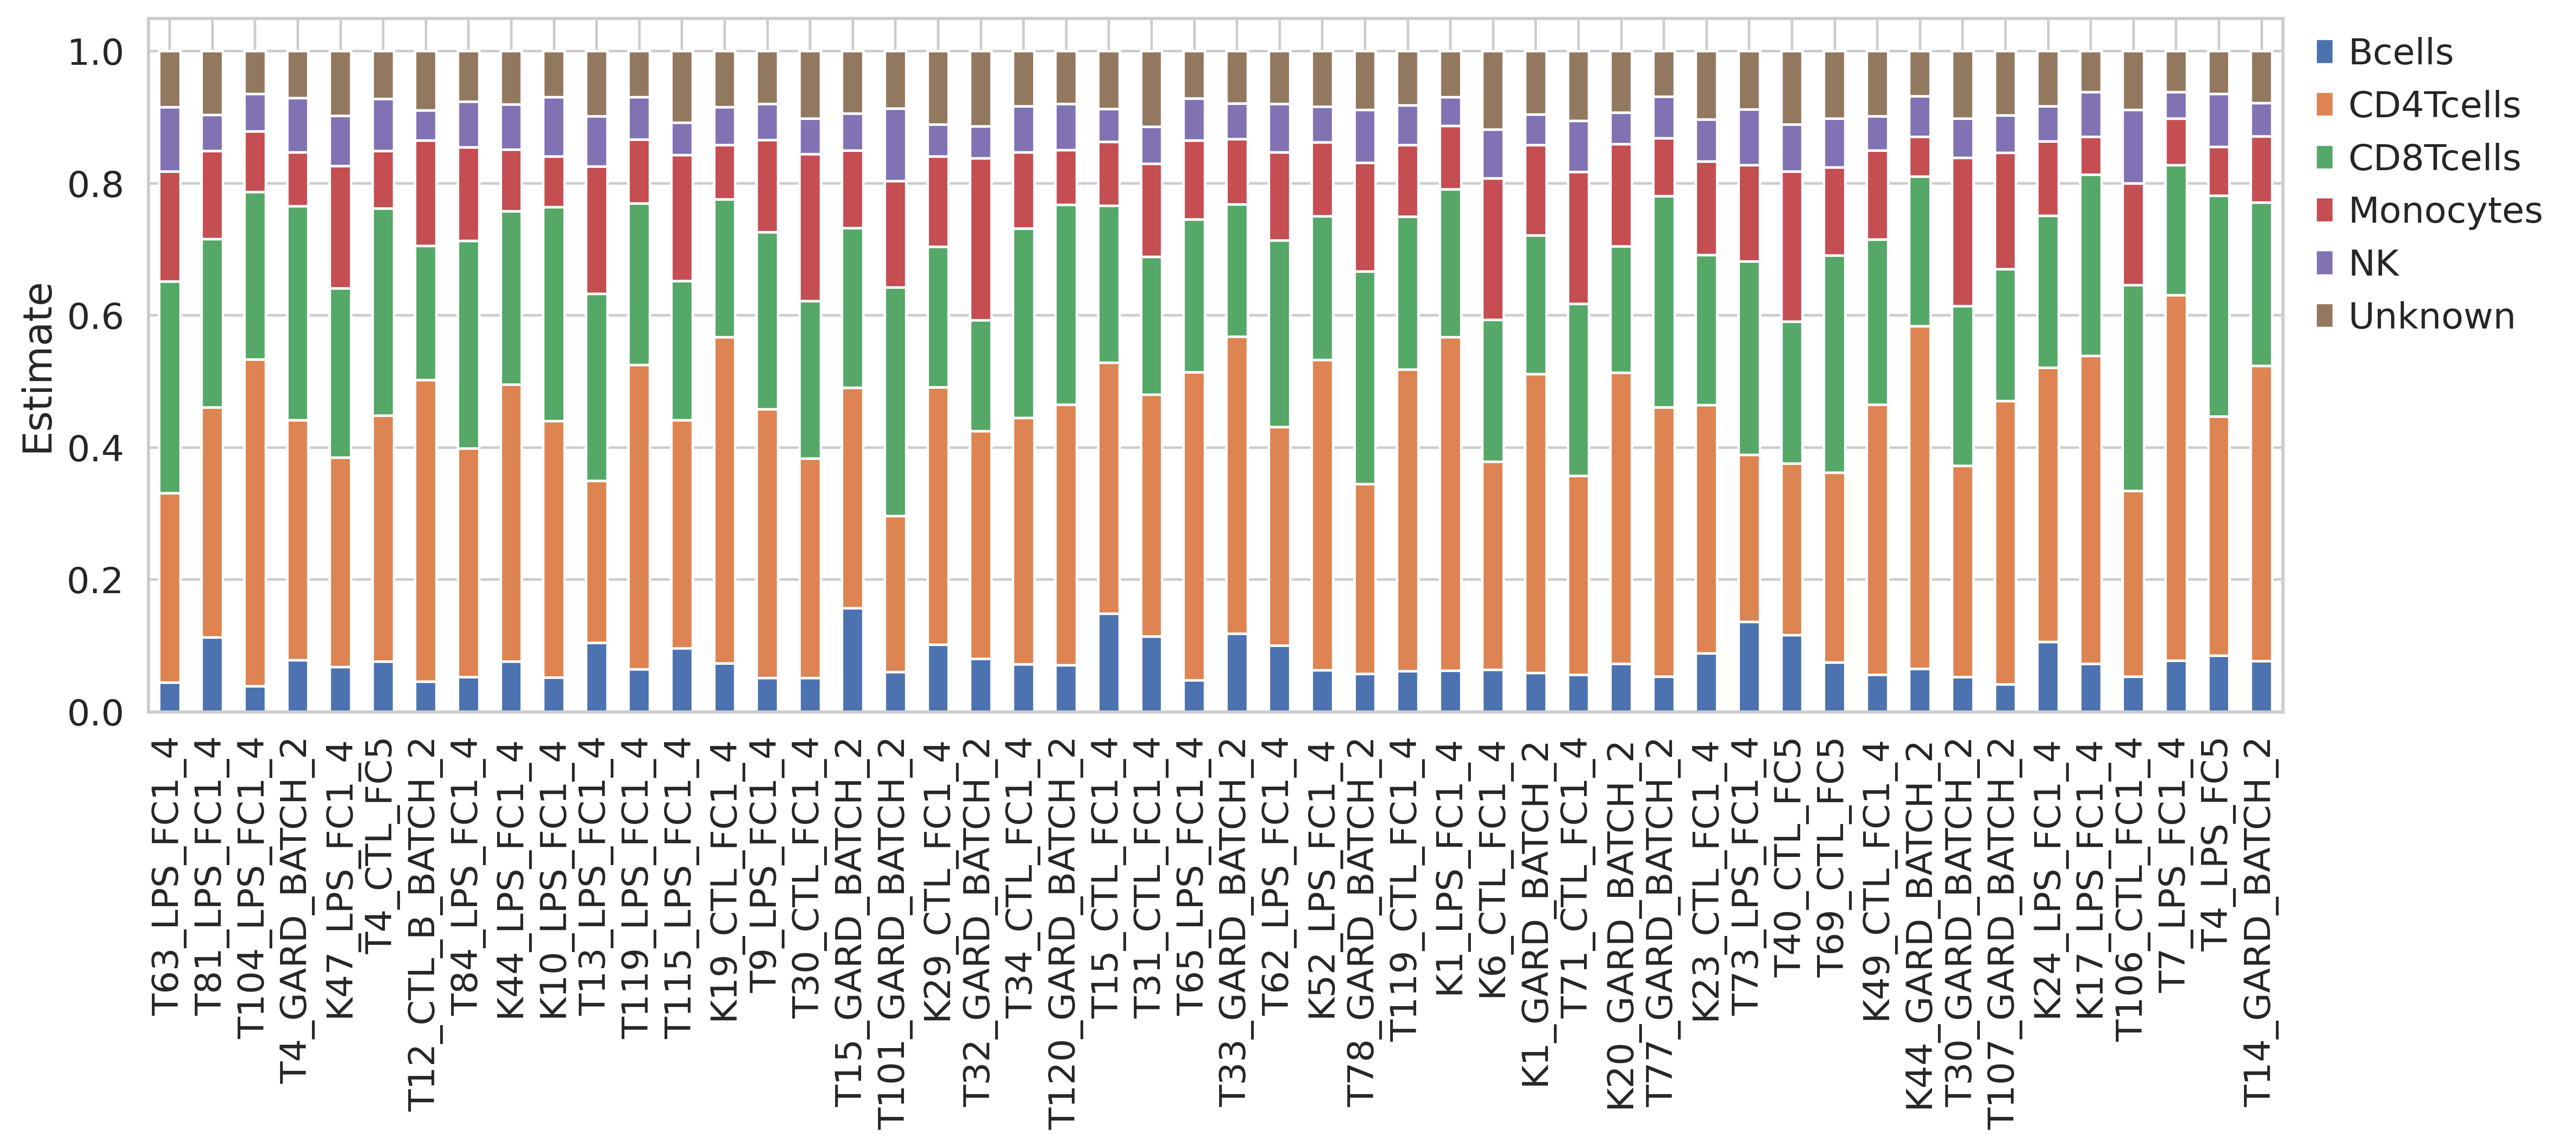

In [18]:
show_samples = 50 # We will show composition of the first 50 samples. 
# show estimates of first 50 samples. More gets hard to see.
df.iloc[0:show_samples,:].plot(kind='bar', stacked=True, figsize=(15,5))
plt.legend(bbox_to_anchor=(1,1.02), frameon=False)
plt.ylabel("Estimate")

In [ ]:
## Show distribution of cell type proportions

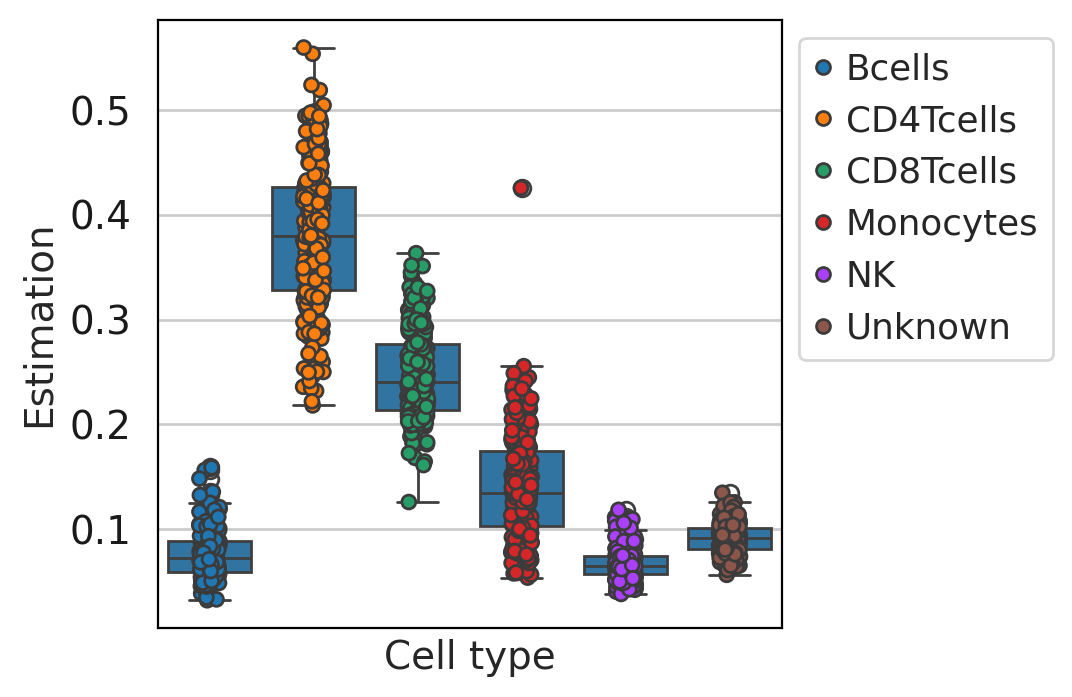

In [47]:
sc.set_figure_params(dpi=100)
melted = df.melt(var_name="Cell type", value_name="Estimation")
ax = sns.boxplot(data=melted, x="Cell type", y="Estimation")

sns.stripplot(data=melted, x="Cell type", y="Estimation", linewidth=1, edgecolor="gray", ax=ax, hue="Cell type", legend=True)
ax.set_xticks([],[])
plt.legend(bbox_to_anchor=(1,1))
plt.show()

-----

## Estimation of cell type specific gene expression 

In [ ]:
# Estimate cell type specific gene expression
dissect.run_dissect_expr(config)

Estimating expression of 11529 common genes
Preparing training datasets.


 29%|██████████████████                                            | 16/55 [10:08<24:58, 38.42s/it]

It saves dataset in two ways:
    
**(1)** an h5ad file (est_expression_layered.h5ad) containing counts of bulkRNAseq in .X and corresponding gene expression for each cell type in layers.

**(2)** an h5ad file (est_expression.h5ad) containing counts of cell type specific gene expressions in .X and corresponding sample and cell type name in .obs.

Let's load our results and see how it is structured, how we can visualize it and use it for downstream analysis.

In [ ]:
adata_est_layered = sc.read("tutorial_bulkRNAseq/est_expression_layered.h5ad")
print(adata_est_layered)

adata_est = sc.read("tutorial_bulkRNAseq/est_expression.h5ad")
print(adata_est)

-----

Since the data object is compatible with Scanpy, default Scanpy functions can be used. Below we shall show two examples

show selected set of genes for each cell type

In [ ]:
sc.set_figure_params(dpi=50)

In [ ]:
genes = ["CD3D", "CD4", "CD8A", "CD19", "LYZ", "FOXP3"]
sc.pl.heatmap(adata_est, var_names=genes, 
              groupby="cell_type", layer="scaled_counts", cmap="RdBu_r")

show expression of highly variable genes

In [ ]:
sc.pp.normalize_total(adata_est_layered, target_sum=1e6)
sc.pp.log1p(adata_est_layered)
sc.pp.highly_variable_genes(adata_est_layered)

In [ ]:
n_hvg = adata_est.var[adata_est.var.highly_variable].sort_values(by="dispersions",
                                                        ascending=False).index[0:10]

In [ ]:
sc.pl.heatmap(adata_est, var_names=n_hvg, 
              groupby="cell_type", layer="scaled_counts", cmap="RdBu_r")

In [ ]:
sc.pl.clustermap(adata_est[:,n_hvg], 
                  obs_keys="cell_type")